In [39]:
import torch
import datetime
import torchvision
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import requests
import tarfile
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
import zipfile
from PIL import Image, ImageEnhance
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(4)
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
t2img = T.ToPILImage()
img2t = T.ToTensor()

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/ADL"

Mounted at /content/drive


In [4]:

# Assuming folder_path is already set to the current working directory
with zipfile.ZipFile(f"{folder_path}/pets_images_final.zip", 'r') as zip_ref:
    zip_ref.extractall("/sample_data")
pretrain_data_path = '/sample_data/pets_images'

In [5]:
# List everything in /tmp
tmp_contents = os.listdir(pretrain_data_path)
print(tmp_contents[:10])

['image_29667.jpg', 'image_19566.jpg', 'image_347.jpg', 'image_1009.jpg', 'image_16220.jpg', 'image_36602.jpg', 'image_30726.jpg', 'image_867.jpg', 'image_19120.jpg', 'image_6255.jpg']


In [6]:
num_workers = os.cpu_count()
num_workers

8

In [7]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])

def greyscale(image):
    grayscale_transform = transforms.RandomGrayscale(p=0.2)
    imgs = []
    for i in range(image.shape[0]):
        im=transforms.ToPILImage()(image[i])
        greyscale_image = grayscale_transform(im)
        imgs.append(transform(greyscale_image).unsqueeze(0))

    return torch.cat(imgs,0)

def distort_color(image):
    color_jitter = transforms.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.1
    )
    imgs=[]
    for i in range(image.shape[0]):
        im=transforms.ToPILImage()(image[i])
        distorted_image = color_jitter(im)
        imgs.append(transform(distorted_image).unsqueeze(0))
    return torch.cat(imgs,0)

def mask_image(image, low_mask_percentage,high_mask_percentage):
    for i in range(image.shape[0]):
        mask_percentage=random.randint(low_mask_percentage,high_mask_percentage)
        rows, cols = image.shape[2:]
        rows_to_mask = int(rows * mask_percentage / 100)
        cols_to_mask = int(cols * mask_percentage / 100)

        top_left_row = random.randint(0, rows - rows_to_mask)
        top_left_col = random.randint(0, cols - cols_to_mask)

        image[i,:, top_left_row:top_left_row + rows_to_mask, top_left_col:top_left_col + cols_to_mask] = 0.5

    return image

distort=transforms.Compose([
    transforms.RandomChoice([lambda x: mask_image(x,5,25),greyscale,distort_color]),
])

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


In [9]:
class CustomImageDataset(Dataset):
    """A custom dataset class for loading preprocessed and saved images."""

    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Path to the directory with preprocessed images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img_name) for img_name in os.listdir(image_dir)
                            if os.path.isfile(os.path.join(image_dir, img_name))]

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to be fetched

        Returns:
            A tuple (image, label), where 'image' is the transformed image tensor,
            and 'label' could be a dummy value if not applicable.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency

        if self.transform:
            image = self.transform(image)

        label = 0
        return image



In [10]:
pre_training_data= CustomImageDataset(pretrain_data_path,transform=transform)
pre_train_dataloader = DataLoader(pre_training_data, batch_size=64, shuffle=True)
len(pre_train_dataloader)

579

In [11]:
class DC2(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        y_shape = y.shape
        y, index = self.max_pool (y)
        return y, index, y_shape

class DC3(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_pool  = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        y_shape = y.shape
        y, index = self.max_pool(y)
        return y, index, y_shape

class UC2(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, index, output_size):
        y = self.max_unpool(x, index, output_size=output_size)
        y = self.seq(y)
        return y

class UC3(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, index, output_size):
        y = self.max_unpool(x, index, output_size=output_size)
        y = self.seq(y)
        return y


class Segnet(torch.nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.out_channels = 3
        self.batch_norm_input = nn.BatchNorm2d(3)
        self.dc_1 = DC2(3, 64, kernel_size=kernel_size)
        self.dc_2 = DC2(64, 128, kernel_size=kernel_size)
        self.dc_3 = DC3(128, 256, kernel_size=kernel_size)
        self.dc_4 = DC3(256, 512, kernel_size=kernel_size)


        self.uc_4 = UC3(512, 256, kernel_size=kernel_size)
        self.uc_3 = UC3(256, 128, kernel_size=kernel_size)
        self.uc_2 = UC2(128, 64, kernel_size=kernel_size)
        self.uc_1 = UC2(64, 3, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.batch_norm_input(batch)

        # SegNet Encoder
        x, max_pool_1_index, s1 = self.dc_1(x)
        x, max_pool_2_index, s2 = self.dc_2(x)
        x, max_pool_3_index, s3 = self.dc_3(x)
        x, max_pool_4_index, s4 = self.dc_4(x)


        # SegNet Decoder

        x = self.uc_4(x, max_pool_4_index, output_size=s4)
        x = self.uc_3(x, max_pool_3_index, output_size=s3)
        x = self.uc_2(x, max_pool_2_index, output_size=s2)
        x = self.uc_1(x, max_pool_1_index, output_size=s1)

        return x

In [21]:
model = Segnet().to(device)
criterion1 =  torch.nn.MSELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [22]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
batch_norm_input.weight 	 torch.Size([3])
batch_norm_input.bias 	 torch.Size([3])
batch_norm_input.running_mean 	 torch.Size([3])
batch_norm_input.running_var 	 torch.Size([3])
batch_norm_input.num_batches_tracked 	 torch.Size([])
dc_1.seq.0.weight 	 torch.Size([64, 3, 3, 3])
dc_1.seq.1.weight 	 torch.Size([64])
dc_1.seq.1.bias 	 torch.Size([64])
dc_1.seq.1.running_mean 	 torch.Size([64])
dc_1.seq.1.running_var 	 torch.Size([64])
dc_1.seq.1.num_batches_tracked 	 torch.Size([])
dc_1.seq.3.weight 	 torch.Size([64, 64, 3, 3])
dc_1.seq.4.weight 	 torch.Size([64])
dc_1.seq.4.bias 	 torch.Size([64])
dc_1.seq.4.running_mean 	 torch.Size([64])
dc_1.seq.4.running_var 	 torch.Size([64])
dc_1.seq.4.num_batches_tracked 	 torch.Size([])
dc_2.seq.0.weight 	 torch.Size([128, 64, 3, 3])
dc_2.seq.1.weight 	 torch.Size([128])
dc_2.seq.1.bias 	 torch.Size([128])
dc_2.seq.1.running_mean 	 torch.Size([128])
dc_2.seq.1.running_var 	 torch.Size([128])
dc_2.seq.1.num_batches_tracked 	 torc

In [23]:
def calculate_supervised_dice_score(predictions, ground_truth):
    """
    Calculate the supervised Dice score for labeled data.

    Args:
        predictions (torch.Tensor): Predictions for labeled data, with shape (batch_size, num_classes, height, width).
        ground_truth (torch.Tensor): Ground truth masks for labeled data, with shape (batch_size, num_classes, height, width).

    Returns:
        torch.Tensor: Supervised Dice score.
    """
    # Convert raw model outputs into probabilities within the range [0, 1] to ensure alignment with the ground truth masks
    predictions = torch.sigmoid(predictions)

    # Smoothing factor to prevent division by zero
    smooth = 1e-5

    # Compute the intersection and union
    intersection = torch.sum(ground_truth * predictions, dim=(1, 2, 3))
    #cardinality = torch.sum(ground_truth, dim=(1, 2, 3)) + torch.sum(predictions, dim=(1, 2, 3))
    cardinality = torch.sum(ground_truth + predictions, dim=(1, 2, 3))

    # Calculate the Dice score
    dice_score = 2 * (intersection + smooth) / (cardinality+ smooth)
    return dice_score.sum()

In [24]:
def calculate_supervised_iou_score(predictions, ground_truth):
    """
    Calculate the supervised IOU score for labeled data.

    Args:
        predictions (torch.Tensor): Predictions for labeled data, with shape (batch_size, num_classes, height, width).
        ground_truth (torch.Tensor): Ground truth masks for labeled data, with shape (batch_size, num_classes, height, width).

    Returns:
        torch.Tensor: Supervised IOU score.
    """
    # Convert raw model outputs into probabilities within the range [0, 1] to ensure alignment with the ground truth masks
    predictions = torch.sigmoid(predictions)

    # Smoothing factor to prevent division by zero
    smooth = 1e-5

    # Compute the intersection and union
    intersection = torch.sum(ground_truth * predictions, dim=(1, 2, 3))
    union = torch.sum(ground_truth, dim=(1, 2, 3)) + torch.sum(predictions, dim=(1, 2, 3)) -intersection

    # Calculate the IOU score
    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score.sum()

In [25]:
def pretrain(net, criterion, optimizer, trainloader, epochs):
    trainloss=[]
    net.train().to(device)
    dl=[]
    iouscore=[]
    for epoch in range(epochs):
        print('Epoch', epoch+1)
        running_loss = 0.0
        dice=0.0
        total=0.0
        iou=0.0
        for i, data in tqdm(enumerate(trainloader, 0)):
            optimizer.zero_grad()
            inputs = data.to(device)
            inputs_distorted=distort(inputs).float().to(device)
            outputs = net(inputs_distorted)
            loss = criterion(outputs, inputs)
            loss.backward(retain_graph=False)
            dice+=calculate_supervised_dice_score(outputs,inputs).item()
            iou+=calculate_supervised_iou_score(outputs,inputs).item()
            optimizer.step()

            running_loss += loss.detach().item()
            total += inputs.size(0)
        trainloss.append(running_loss/total)
        iouscore.append(iou/total)
        dl.append(dice/total)
        print('[%d, %2d]   loss: %.5f Dice Score: %.5f IOU Score: %.5f'  %
                    (epoch + 1,epochs, trainloss[epoch],dl[epoch] ,iouscore[epoch]))
    return trainloss , dl , iouscore

In [26]:
mse , dlpt, iou = pretrain(model, criterion1, optimizer, pre_train_dataloader, 20)

Epoch 1


579it [03:14,  2.98it/s]


[1, 20]   loss: 0.00051 Dice Score: 0.52213 IOU Score: 0.35732
Epoch 2


579it [03:12,  3.01it/s]


[2, 20]   loss: 0.00020 Dice Score: 0.52804 IOU Score: 0.36285
Epoch 3


579it [03:09,  3.06it/s]


[3, 20]   loss: 0.00015 Dice Score: 0.52924 IOU Score: 0.36399
Epoch 4


579it [03:11,  3.03it/s]


[4, 20]   loss: 0.00012 Dice Score: 0.52985 IOU Score: 0.36458
Epoch 5


579it [03:17,  2.94it/s]


[5, 20]   loss: 0.00011 Dice Score: 0.53007 IOU Score: 0.36480
Epoch 6


579it [03:09,  3.06it/s]


[6, 20]   loss: 0.00009 Dice Score: 0.53044 IOU Score: 0.36516
Epoch 7


579it [03:15,  2.96it/s]


[7, 20]   loss: 0.00009 Dice Score: 0.53035 IOU Score: 0.36507
Epoch 8


579it [03:12,  3.01it/s]


[8, 20]   loss: 0.00008 Dice Score: 0.53069 IOU Score: 0.36541
Epoch 9


579it [03:13,  2.99it/s]


[9, 20]   loss: 0.00007 Dice Score: 0.53076 IOU Score: 0.36547
Epoch 10


579it [03:11,  3.02it/s]


[10, 20]   loss: 0.00007 Dice Score: 0.53083 IOU Score: 0.36555
Epoch 11


579it [03:14,  2.98it/s]


[11, 20]   loss: 0.00006 Dice Score: 0.53096 IOU Score: 0.36568
Epoch 12


579it [03:09,  3.06it/s]


[12, 20]   loss: 0.00006 Dice Score: 0.53098 IOU Score: 0.36569
Epoch 13


579it [03:12,  3.01it/s]


[13, 20]   loss: 0.00006 Dice Score: 0.53099 IOU Score: 0.36570
Epoch 14


579it [03:13,  2.99it/s]


[14, 20]   loss: 0.00006 Dice Score: 0.53101 IOU Score: 0.36573
Epoch 15


579it [03:13,  2.99it/s]


[15, 20]   loss: 0.00006 Dice Score: 0.53090 IOU Score: 0.36562
Epoch 16


518it [02:51,  3.03it/s]


KeyboardInterrupt: 

In [27]:
model_path = os.path.join(folder_path, f'segnet_pretrained_MSE.pt')
torch.save(model.state_dict(), model_path)

In [29]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Streaming output truncated to the last 5000 lines.
        -1.0551e-07, -2.0181e-07, -3.9388e-07, -3.0866e-07,  8.7943e-08,
         2.3022e-07,  5.6095e-08, -1.3072e-07, -1.0784e-08,  7.0638e-07,
         1.0952e-07, -1.7531e-08, -3.0550e-08,  2.9686e-07, -7.1015e-07,
         3.1936e-07,  1.2105e-08,  2.1635e-07,  2.8033e-07,  9.5022e-07,
         6.8823e-08, -1.8393e-07,  2.1357e-08,  1.2004e-07, -3.0855e-07,
         5.4712e-07,  4.4318e-07, -1.4454e-07,  8.5820e-08, -4.1620e-07,
        -9.1684e-08,  1.1178e-06, -3.3869e-07, -4.1297e-07, -2.9656e-07,
         4.9931e-08,  2.7295e-07,  4.7969e-08, -6.1995e-08,  9.5355e-09,
        -2.5619e-07,  1.8882e-07, -4.8356e-08,  3.7515e-08, -2.8378e-07,
        -2.9259e-08, -8.4802e-08,  4.4064e-08,  1.2573e-07,  1.6617e-06,
         1.4988e-07,  3.0873e-07,  1.7296e-07, -8.2521e-08, -3.5654e-08,
         3.8440e-07, -1.0791e-07, -7.8281e-07,  3.9889e-08,  2.5781e-06,
         5.4443e-08, -6.0528e-09,  3.7600e-06, -2.1901e-07,  4.8130e-07,


In [30]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])
target_transform=transforms.Compose([
    transforms.Resize((120, 120),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.nn.functional.one_hot((x*255).long() - 1,3).squeeze(0).permute(2,0,1))

])



training_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='trainval',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True,num_workers=num_workers)




testing_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)
test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=False,num_workers=num_workers)

100%|██████████| 791918971/791918971 [00:04<00:00, 180826514.87it/s]


Extracting data/oxford-pets/oxford-iiit-pet/images.tar.gz to data/oxford-pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 93870703.79it/s] 


Extracting data/oxford-pets/oxford-iiit-pet/annotations.tar.gz to data/oxford-pets/oxford-iiit-pet


In [31]:
(train_pets_inputs, train_pets_targets) = next(iter(train_dataloader))

train_pets_inputs.shape, train_pets_targets.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([64, 3, 120, 120]), torch.Size([64, 3, 120, 120]))

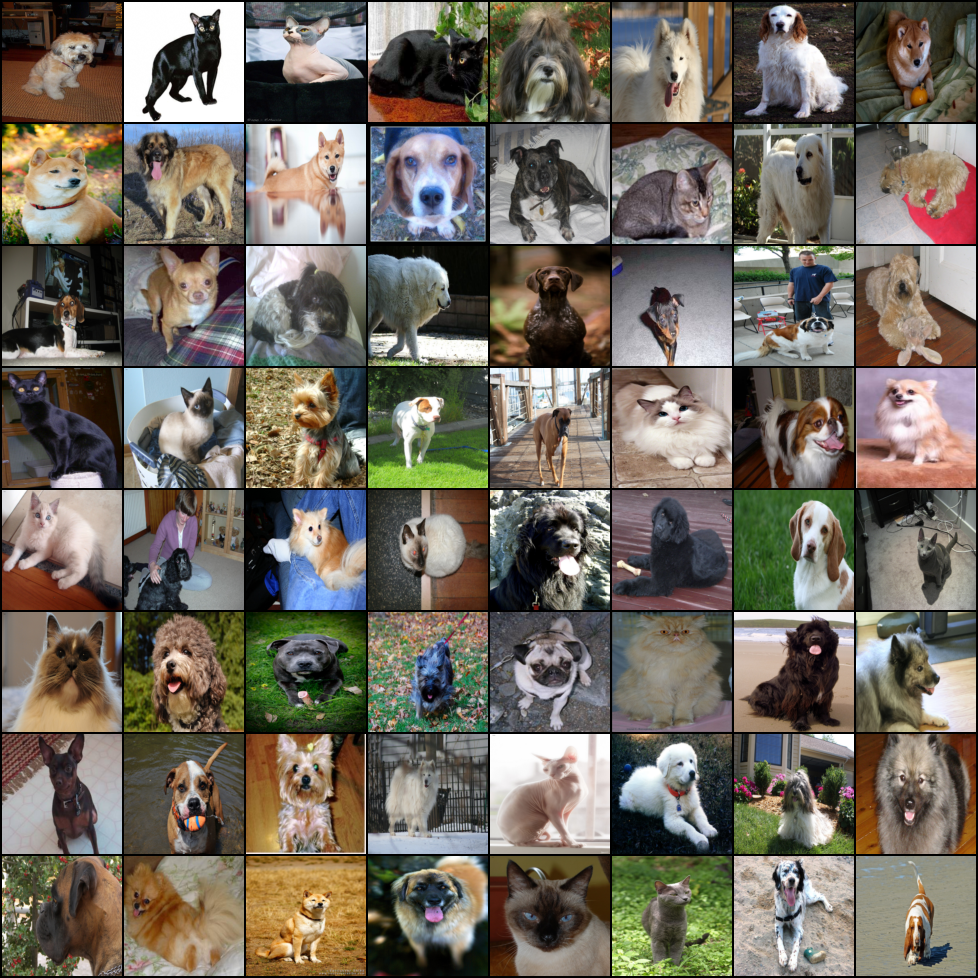

In [32]:
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

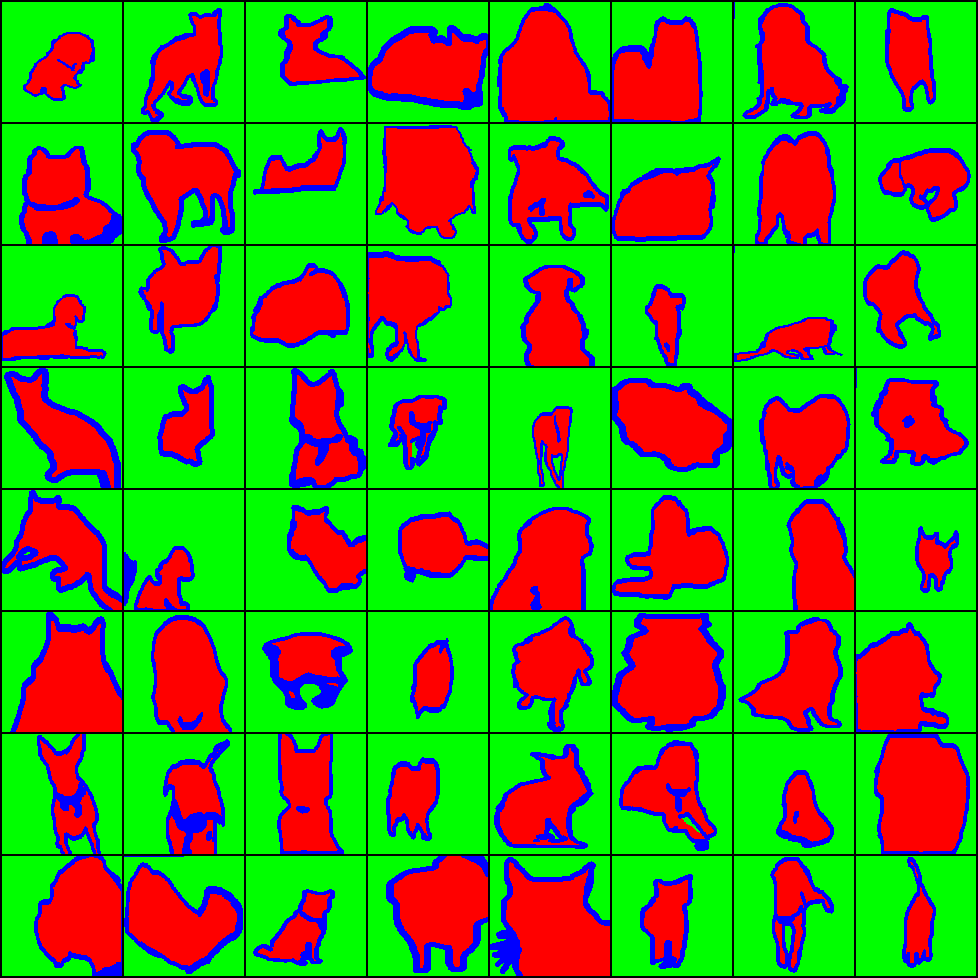

In [33]:
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets /1. , nrow=8)
t2img(pets_targets_grid)

In [34]:
def train(net, criterion, optimizer, trainloader, epochs):
    trainloss=[]
    dl=[]
    iouscore=[]
    net.train().to(device)
    for epoch in range(epochs):

        print('Epoch', epoch+1)
        running_loss = 0.0
        dice=0.0
        total=0.0
        iou=0.0
        acc=0.0
        for  batch_idx, data in tqdm(enumerate(trainloader, 0)):
            optimizer.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = net(inputs)


            loss = criterion(outputs, labels)






            loss.backward(retain_graph=False)
            dice+=calculate_supervised_dice_score(outputs,labels).item()
            iou+=calculate_supervised_iou_score(outputs,inputs).item()
            acc+=torch.mean((torch.argmax(outputs,1)==torch.argmax(labels,1)).float(),dim=(1, 2)).sum().item()
            optimizer.step()
            running_loss += loss.detach().item()
            total += inputs.size(0)
        dl.append(dice/total)
        iouscore.append(iou/total)
        print("accuracy:", acc / total)
        trainloss.append(running_loss/total)
        print('[%d, %2d]   loss: %.5f Dice Score: %.5f IOU Score: %.5f'  %
                    (epoch + 1,epochs, trainloss[epoch],dl[epoch] ,iouscore[epoch]))

    return trainloss , dl , iouscore

In [48]:
tl , dl,iou = train(model, criterion1, optimizer, train_dataloader, 20)

Epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
58it [00:11,  5.16it/s]

accuracy: 0.9315653106440669
[1, 20]   loss: 0.00053 Dice Score: 0.51893 IOU Score: 0.33119
Epoch 2



58it [00:11,  5.15it/s]

accuracy: 0.9373163622358571
[2, 20]   loss: 0.00048 Dice Score: 0.52025 IOU Score: 0.33105
Epoch 3



58it [00:11,  5.18it/s]

accuracy: 0.9411925191464632
[3, 20]   loss: 0.00045 Dice Score: 0.52116 IOU Score: 0.33102
Epoch 4



58it [00:11,  5.17it/s]

accuracy: 0.9434934864873471
[4, 20]   loss: 0.00044 Dice Score: 0.52174 IOU Score: 0.33101
Epoch 5



58it [00:11,  5.09it/s]

accuracy: 0.9453599432240362
[5, 20]   loss: 0.00042 Dice Score: 0.52213 IOU Score: 0.33099
Epoch 6



58it [00:11,  5.13it/s]

accuracy: 0.9465070102525794
[6, 20]   loss: 0.00041 Dice Score: 0.52253 IOU Score: 0.33097
Epoch 7



58it [00:11,  5.16it/s]

accuracy: 0.9485320080881533
[7, 20]   loss: 0.00040 Dice Score: 0.52283 IOU Score: 0.33097
Epoch 8



58it [00:11,  5.16it/s]

accuracy: 0.9503264484198197
[8, 20]   loss: 0.00038 Dice Score: 0.52325 IOU Score: 0.33092
Epoch 9



58it [00:11,  5.10it/s]

accuracy: 0.9524486002714737
[9, 20]   loss: 0.00037 Dice Score: 0.52398 IOU Score: 0.33097
Epoch 10



58it [00:11,  5.15it/s]

accuracy: 0.9535762610642806
[10, 20]   loss: 0.00036 Dice Score: 0.52415 IOU Score: 0.33098
Epoch 11



58it [00:11,  5.14it/s]

accuracy: 0.9538000464439392
[11, 20]   loss: 0.00036 Dice Score: 0.52417 IOU Score: 0.33091
Epoch 12



58it [00:11,  5.15it/s]

accuracy: 0.9553601332332777
[12, 20]   loss: 0.00035 Dice Score: 0.52466 IOU Score: 0.33094
Epoch 13



58it [00:11,  5.13it/s]

accuracy: 0.9567787450292836
[13, 20]   loss: 0.00034 Dice Score: 0.52487 IOU Score: 0.33091
Epoch 14



58it [00:11,  5.16it/s]

accuracy: 0.9586480980334074
[14, 20]   loss: 0.00032 Dice Score: 0.52534 IOU Score: 0.33091
Epoch 15



58it [00:11,  5.11it/s]

accuracy: 0.9611879390218984
[15, 20]   loss: 0.00030 Dice Score: 0.52597 IOU Score: 0.33094
Epoch 16



58it [00:11,  5.16it/s]

accuracy: 0.9609771142835203
[16, 20]   loss: 0.00031 Dice Score: 0.52577 IOU Score: 0.33090
Epoch 17



58it [00:11,  5.11it/s]

accuracy: 0.9617681949034981
[17, 20]   loss: 0.00030 Dice Score: 0.52601 IOU Score: 0.33088
Epoch 18



58it [00:11,  5.02it/s]

accuracy: 0.9635710405266803
[18, 20]   loss: 0.00029 Dice Score: 0.52639 IOU Score: 0.33087
Epoch 19



58it [00:11,  5.12it/s]

accuracy: 0.9649073123931885
[19, 20]   loss: 0.00028 Dice Score: 0.52695 IOU Score: 0.33093
Epoch 20



58it [00:11,  5.11it/s]

accuracy: 0.9660748849744382
[20, 20]   loss: 0.00027 Dice Score: 0.52691 IOU Score: 0.33086


In [26]:
model_path = os.path.join(folder_path, f'segnet_trained_MSE.pt')
torch.save(model.state_dict(), model_path)

In [54]:
def test(model,  test_data, epochs=20):
    testacc=[]
    ds=[]
    iouscore=[]
    model.eval().to(device)
    for epoch in range(epochs):
        print('Epoch',epoch+1)
        dice=0.0
        total=0.0
        acc=0.0
        iou=0.0
        with torch.no_grad():
            for batch_idx, data in tqdm(enumerate(test_data, 0)):
                inputs , labels = data
                #inputs,labels = inputs.to(device), labels.to(device)
                #print(labels.shape,'label')
                #print(inputs.shape,'input')
                #predictions = model(inputs)
                #print(predictions.shape,'pred')
                #print(predictions.shape,labels.shape)
                #pred = nn.Softmax(dim=1)(predictions)

                inputs,labels = inputs.to(device), labels.to(device)
                #print(labels.shape,'label')
                #print(inputs.shape,'input')

                predictions = model(inputs)



                #pred = nn.Softmax(dim=1)(predictions)

                #pred_labels = pred.argmax(dim=1)
                #print(pred_labels.shape)
                #pred_labels = pred_labels.unsqueeze(1)
                #print(pred_labels.shape)

                #pred_mask = pred_labels.to(torch.float)
                acc+=torch.mean((torch.argmax(predictions,1)==torch.argmax(labels,1)).float(),dim=(1, 2)).sum().item()
                dice +=calculate_supervised_dice_score(predictions,labels).item()
                #acc += IoUMetric(pred, labels).detach().item()
                iou+=calculate_supervised_iou_score(predictions,labels).item()
                #pred_labels = predictions.argmax(dim=1)
                #print(pred_labels.shape)
                #pred_labels = pred_labels.unsqueeze(1)
                #print(pred_labels.shape)
                #pred_mask = pred_labels.to(torch.float)
                #print(pred_mask.shape)
                #dice+=calculate_supervised_dice_score(predictions,labels).item()
                total += inputs.size(0)



        ds.append(dice/total)
        iouscore.append(iou/total)
        testacc.append(acc/total)
        print('Testing : [%d, %2d]   Dice Score: %.5f IOU Score: %.5f Accuracy : %.5f ' %
                    (epoch + 1,epochs,   ds[epoch] ,iouscore[epoch],testacc[epoch]))
        if (epoch +1 == 1):
          fig = plt.figure(figsize=(10, 12))
          fig.suptitle('Images', fontsize=12)

          fig.add_subplot(3, 1, 1)
          plt.imshow(t2img(torchvision.utils.make_grid(inputs, nrow=8)))
          plt.axis('off')
          plt.title("Targets")

          fig.add_subplot(3, 1, 2)
          plt.imshow(t2img(torchvision.utils.make_grid(labels.float()/1.0 , nrow=8)))
          plt.axis('off')
          plt.title("Ground Truth Labels")

          fig.add_subplot(3, 1, 3)
          plt.imshow(t2img(torchvision.utils.make_grid(predictions, nrow=8)))
          plt.axis('off')
          plt.title("Predicted Labels")
    return

Epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
453it [00:08, 67.02it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
459it [00:08, 55.95it/s]


Testing : [1,  1]   Dice Score: 0.51393 IOU Score: 0.34592 Accuracy : 0.87935 


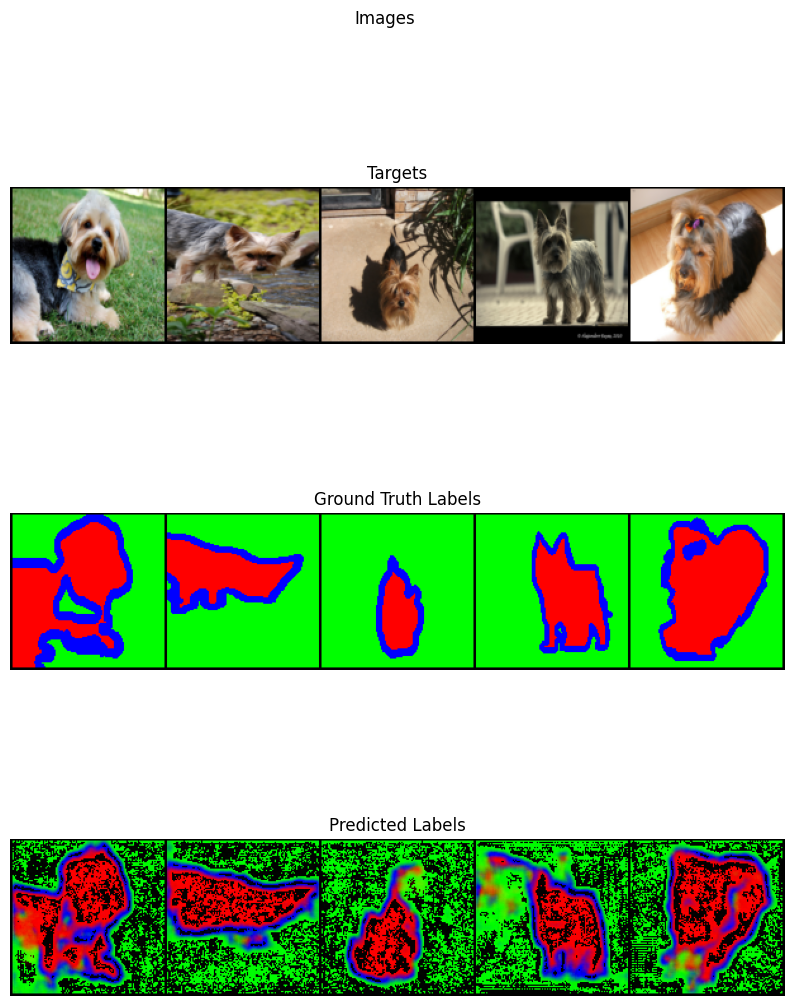

In [55]:
test(model,  test_dataloader, epochs=1)